In [1]:
%pylab inline
import LFPy

Populating the interactive namespace from numpy and matplotlib
Failed to setup nrnpy_pr


/home/ben/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cellParameters = {
    'morphology' : 'ball_and_sticks.hoc',
    'tstart' : -50,
    'tstop' : 200,
    'dt' : 2**-4,
    'passive': True,
    'passive_parameters': {'g_pas':0.001, 'e_pas':-70},
    'nsegs_method': 'fixed_length',
    'max_nsegs_length':26
}

SynapseParameters = {
    'syntype' : 'Exp2Syn',
    'e' : 0,
    'tau1' : 0.5,
    'tau2' : 2.0,
    'weight' : 0.003,
    'record_current' : True,
}

z = mgrid[-1200:1201:100]
electrodeParameters = {
    'x' : zeros(z.size),
    'y' : zeros(z.size),
    'z' : z,
    'sigma' : 0.3,
}

In [3]:
# Cell 1
cell = LFPy.Cell(**cellParameters)
cell.set_pos(x=-250, y=0, z=0)
cell.set_rotation(z=np.pi)


synapse1 = LFPy.Synapse(cell,
                       idx = cell.get_closest_idx(x=-250,z=-50),
                       **SynapseParameters)

synapse1.set_spike_times(array([50]))       

synapse2 = LFPy.Synapse(cell,
                       idx = cell.get_closest_idx(x=-250,z=500),
                       **SynapseParameters)

synapse2.set_spike_times(array([150]))  

electrode = LFPy.RecExtElectrode(**electrodeParameters)

In [4]:
import neuron
def record_dend(Cell):
    """
    Record membrane potentials for dend segments
    """
    dendvreclist = neuron.h.List()
    for sec in Cell.allseclist:
        if ~sec.name().find('dend'):
            memvrec = neuron.h.Vector(int(Cell.tstop / Cell.dt+1))
            memvrec.record(sec(0.5)._ref_v, Cell.dt)
            dendvreclist.append(memvrec)
    return dendvreclist
dendvreclist = record_dend(cell)

cell.simulate(electrode=electrode,rec_imem=True,rec_ipas=True,rec_icap=True)

(<matplotlib.collections.QuadMesh at 0x7fde5c6b4b10>,
 Text(0.5,1,'LFP (mV)'))

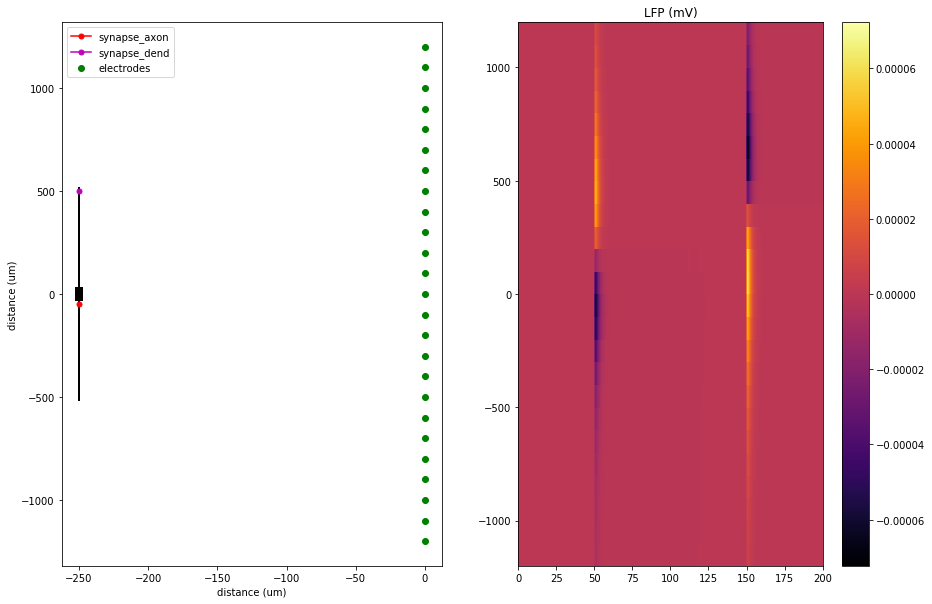

In [5]:
figure(figsize=(15, 10))
#subplot(2,3,4)


subplot(1,2,1)
# Plot geometry of the cell
for sec in LFPy.cell.neuron.h.allsec():
    idx = cell.get_idx(sec.name())
    if sec.name()=="soma[0]":
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.zstart[idx], cell.zend[idx][-1]],
            'k',linewidth=8)
    else:
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.zstart[idx], cell.zend[idx][-1]],
            'k',linewidth=2)
# Plot synapse as red dot
plot([cell.synapses[0].x], [cell.synapses[0].z], \
     color='r', marker='o', markersize=5,label='synapse_axon')
plot([cell.synapses[1].x], [cell.synapses[1].z], \
     color='m', marker='o', markersize=5,label='synapse_dend')
# Plot electrodes as green dots
plot(electrode.x, electrode.z, '.', marker='o', color='g',label='electrodes')

xlabel('distance (um)')
ylabel('distance (um)')

legend()

        
#### Calculate extracellular potential by hand
'''
# electrode 5 is at 0,100
h = np.zeros((5,1))
l = np.zeros((5,1))
r = np.zeros((5,1))

for i in np.arange(0,5):
    h[i,0] = electrode.z[5]-cell.zend[i]
    l[i,0] = electrode.z[5]-cell.zstart[i]
    r[i,0] = electrode.x[5]-cell.xstart[i]

dist = np.log((np.sqrt(h**2+r**2)-h)/(np.sqrt(l**2+r**2)-l))
v_ext=1000*(1/(4*np.pi*300*5))*np.dot(np.transpose(cell.imem),dist)
'''
subplot(1,2,2)
pcolormesh(cell.tvec, electrode.z, electrode.LFP,
           vmin=-abs(electrode.LFP).max(), vmax=abs(electrode.LFP).max(),
           cmap='inferno'), colorbar(), title('LFP (mV)')


In [6]:
cell.imem.shape

(41, 3201)

19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


(-0.001, 0.01)

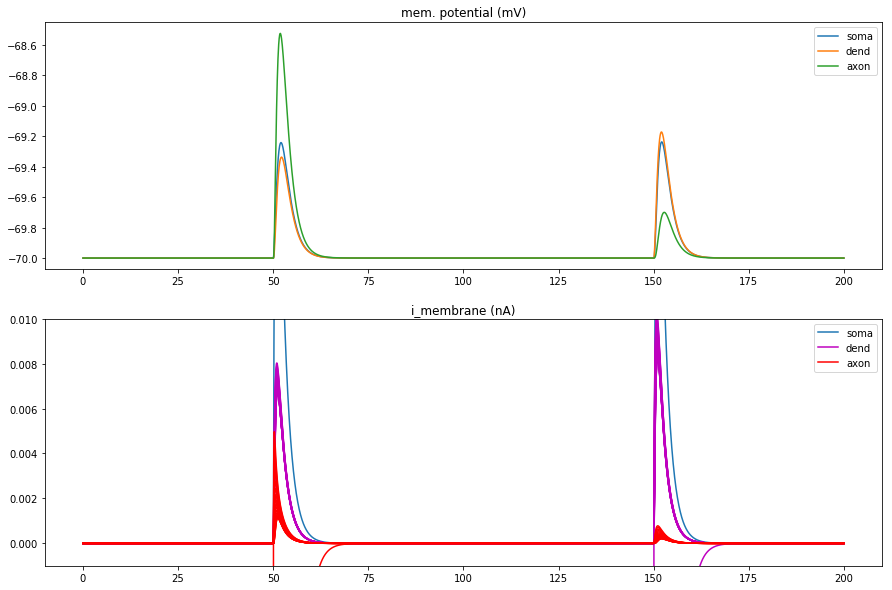

In [14]:
figure(figsize=(15, 10))
subplot(2,1,1)
plot(cell.tvec,cell.somav,label='soma')
c=0
for x in dendvreclist:
    c = c+1
    y = np.array(x)
    if c==1:
        plot(cell.tvec,y,label='dend')
    else:
        plot(cell.tvec,y,label='axon')
legend()
title('mem. potential (mV)')

imem_mat = np.zeros((41,cell.imem.shape[1]))
subplot(2,1,2)
plot(cell.tvec,cell.imem[0],label='soma')
imem_mat[20,:] = cell.imem[0]
p=1
for i in np.arange(1,21):
    if i==1:
        plot(cell.tvec,cell.imem[i],'m',label='dend')  
    else:
        plot(cell.tvec,cell.imem[i],'m')
    imem_mat[i+20,:] = cell.imem[i]
    
for i in np.arange(21,41):
    if i==21:
        plot(cell.tvec,cell.imem[i],'r',label='axon')
    else:
        plot(cell.tvec,cell.imem[i],'r')
    imem_mat[i-2*p,:]=cell.imem[i]
    p=p+1
title('i_membrane (nA)')
legend()
ylim(-0.001,0.01)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.36294283e-14
   1.32319970e-14  1.28920260e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.37156083e-14
   1.32583834e-14  1.28672638e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.39009340e-14
   1.34937050e-14  1.29925928e-14]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.00241629e-13
   2.91361928e-13  2.83462253e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.03768195e-13
   2.93826646e-13  2.84954764e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.47299382e-12
  -6.27377767e-12 -6.08158934e-12]]


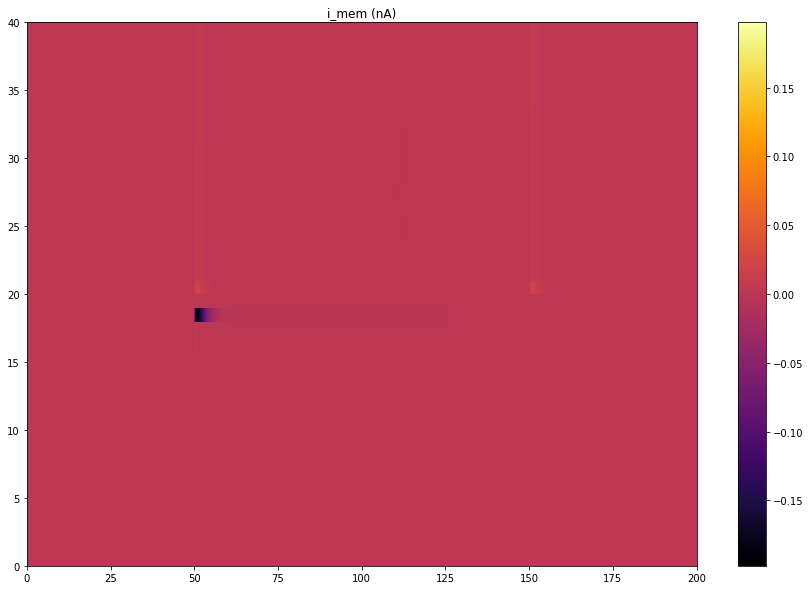

In [18]:
figure(figsize=(15, 10))
pcolormesh(cell.tvec, np.arange(0,cell.imem.shape[0]), imem_mat,
           vmin=-abs(cell.imem).max(), vmax=abs(cell.imem).max(),
           cmap='inferno'), colorbar(), title('i_mem (nA)')
print(imem_mat)